# TP ACP 2

Dans ce TP, nous allons étendre notre résumé à une dimension fait au TP précédent à plusieurs dimensions. Nous allons également reconstruire les données compressées, et appliquer cette reconstruction à des images. 

### Compétences associées :

| Numéro        | Compétence           | 
|:------------- |:--------------------:|
|AS405|	Savoir déterminer la matrice de projection au sens de l’ACP|
|AS406|	Savoir déterminer la projection des données sur un sous espace vectoriel au sens de l’ACP|
|AS407|	Savoir interpréter les valeurs propres en fonction de chaque axe factoriel|
|AS408|	Savoir expliciter la transformation inverse pour reconstruire les données|
|AS409|	Connaître les limites de l’ACP|
|PY306|	Savoir calculer la variance correspondant à k premiers axes factoriels|
|PY307|	Savoir calculer une ACP en d dimensions sur un jeu de données|
|PY308|	Être capable de reconstruire une image après ACP|



## Ex1 : Information expliquée 

1) Chargez le dataset Iris et normalisez les données. Gardez les 'targets', c'est à dire les noms d'espèces de chaque plante dans un vecteur `y`. Vous pouvez utiliser l'option `return_X_y=True` de la fonction `load_iris`.


In [1]:
from sklearn.datasets import load_iris
import numpy as np
X,y = load_iris(return_X_y=True)
n,p = X.shape
mu,std = np.mean(X,axis=0), np.std(X,axis=0)
X = (X- mu)/std

2. Plottez les données `X` en 2D (les variables au choix) et affichez chaque point avec une couleur par espèce. Vous pouvez utiliser le paramètre `c=y` pour y arriver facilement.

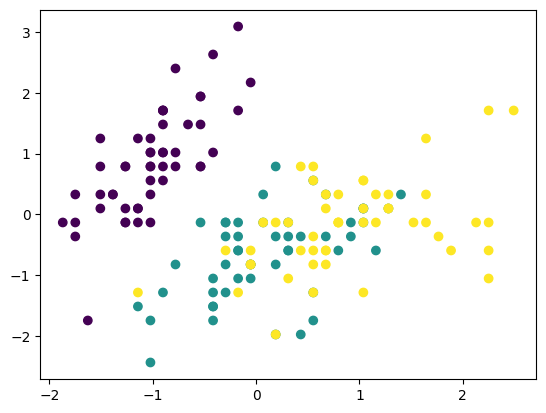

In [2]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c=y)

Nous allons calculer l'ACP de ces données. Vous pouvez aller vite en utilisant `sklearn.decomposition.PCA` mais il est également important de savoir coder la méthode pour bien la comprendre. Dans les questions suivantes, nous allons détailler pas à pas commment calculer la PCA avec `numpy`. La version `sklearn` est donnée plus loin. 

3.Calculez la décomposition valeurs propres/vecteurs propres de la matrice de variance/covariance associées aux données normalisées.

In [3]:
cov = (X.T@X)/n # La division par n n'est pas obligatoire. Juste ne pas oublier dans l'interprétation des variances 
w,v = np.linalg.eigh(cov)

4. Triez les valeurs propres dans l'ordre décroissant et appliquez le même ordre de tri aux colonnes de la matrice des vecteurs propres.

**Aide** : 

    1. On pourra utiliser la fonction `argsort` de `numpy`. [doc](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html)
    2. L'utilisation des slices avec `-1` en dernière position permet de parcourir un élément de la fin au début. cf exemple.

In [4]:
a = np.array([3,1,5,2,4]) # un vecteur
print(a)
print(a[::-1]) # un vecteur affiché "à l'envers"
print(np.argsort(a)) # affiche les positions de chaque élement dans l'ordre croissant
sorted_indexes = np.argsort(a)
print(a[sorted_indexes]) #applique le tri "sorted_indexes" à "a"
print(np.argsort(a)[::-1]) # affiche les positions de chaque élement dans l'ordre décroissant



[3 1 5 2 4]
[4 2 5 1 3]
[1 3 0 4 2]
[1 2 3 4 5]
[2 4 0 3 1]


In [5]:
indexes = np.argsort(w)[::-1]
w=w[indexes]
v=v[:,indexes]

5. Calculez la matrice de projection $P$ de $R^4$ vers $R^2$, en prenant les deux premiers axes de l'ACP. Projetez les données $X$ avec $P$. Maintenant que nous sommes en 2D, plottez les données avec une couleur par espèce. Comparez avec le premier plot.

In [6]:
P = v[:,:2]
Xproj = X@P

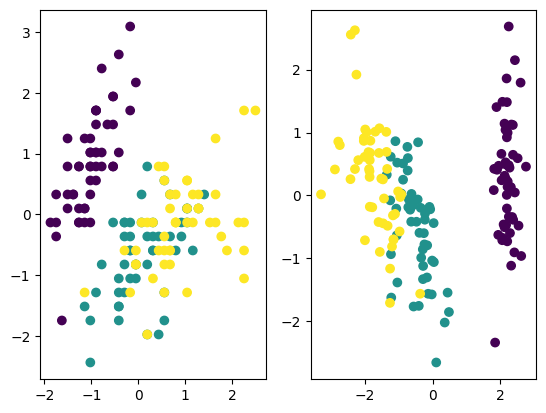

In [7]:
plt.subplot(121)
plt.scatter(X[:,0],X[:,1],c=y)
plt.subplot(122)
plt.scatter(Xproj[:,0],Xproj[:,1],c=y)
#meilleure séparation même si pas parfaite.

6. Comme vu en cours, la variance expliquée par chaque axe est donnée par la  valeur propre associée à ce même axe. Calculez le pourcentage de variance expliqué par chaque axe. On pourra afficher cette information avec `plt.bar(np.arange(4), ...)`

[72.96244541 22.85076179  3.66892189  0.51787091]


<BarContainer object of 4 artists>

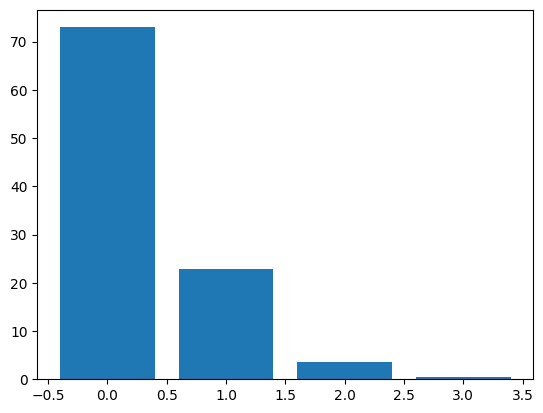

In [8]:
pourcent_var = (w/w.sum())*100
print(pourcent_var)
plt.bar(np.arange(4),height=pourcent_var)

7. Enfin, affichez le pourcentage cumulé de variance expliqué en prenant les $p$ premiers axes. Que pouvez vous en conclure ?

<BarContainer object of 4 artists>

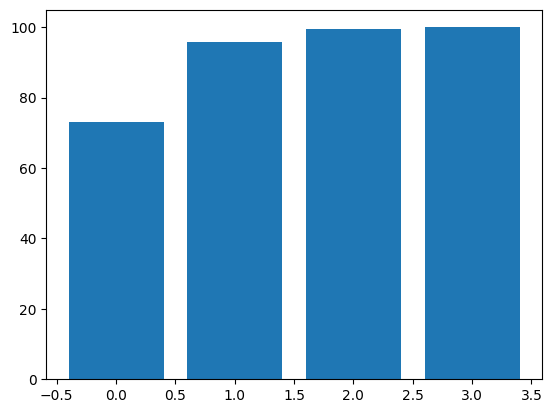

In [9]:

plt.bar(np.arange(4),height=np.cumsum(pourcent_var))

**Bonus** : Faites la même analyse sur Diabetes ou d'autres datasets.

**Bonus 2**  : la même chose avec sklearn :

<BarContainer object of 4 artists>

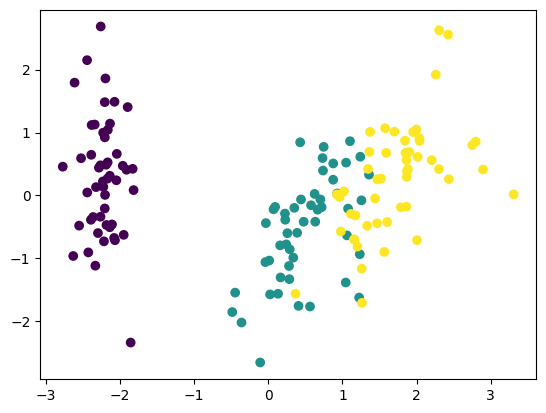

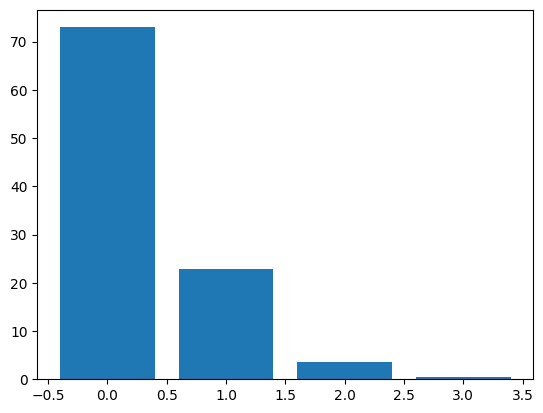

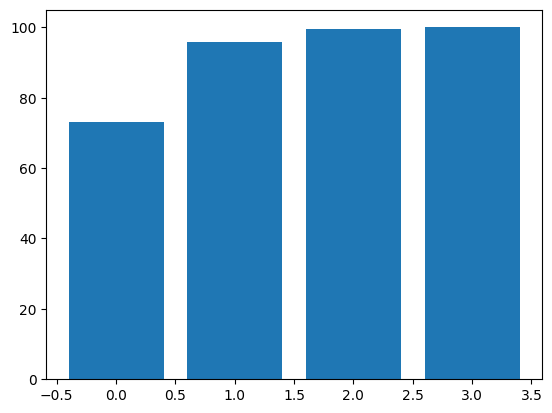

In [10]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X,y = load_iris(return_X_y=True)
scaler = StandardScaler()
#on normalise nos données
X_norm = scaler.fit_transform(X) 
#on calcule la PCA
pca = PCA() #ici on peut spécifier le nb de composants. Si on a pas besoin de tout, cela peut nous faire gagner du temps de calcul
pca.fit(X_norm)
X_proj =pca.transform(X_norm)
plt.scatter(X_proj[:,0],X_proj[:,1],c=y)

plt.figure()
plt.bar(np.arange(4),pca.explained_variance_ratio_*100)
plt.figure()
plt.bar(np.arange(4),np.cumsum(pca.explained_variance_ratio_)*100)



## Ex2 : Reconstruction
Ici nous allons étudier la reconstruction d'une image suite à une ACP, et après avoir gardé qu'une partie des composantes principales. Cet exercice nous permettra de mettre en évidence les capacités de compression des méthodes basées sur l'ACP.

1) Charger l'image du cameraman, une image bien connue pour le traitement d'images. Cette image étant en niveaux de gris, nous allons pouvoir la représenter sous forme d'une matrice `X` $\in \mathbb{R}^{256 \times 256}$. Ici, nous faisons l'hypothèse que chaque ligne de l'image est une observation, et que chaque colonne est une variable. Vous pouvez afficher l'image avec `plt.imshow(X,cmap="gray")`.

In [11]:
import imageio.v2 as imageio
import matplotlib.pyplot as plt
X = imageio.imread('cameraman.png')
plt.imshow(X,cmap="gray");

ModuleNotFoundError: No module named 'imageio'

2. Calculez l'ACP (en utilisant votre code ou `sklearn`) de l'image codée par `X`

In [ ]:
import numpy as np
mu,std = np.mean(X,axis=0), np.std(X,axis=0)
Xnorm = (X - mu ) / std
cov = Xnorm.T@Xnorm
w,v = np.linalg.eigh(cov)

In [ ]:
indexes = w.argsort()[::-1]
w=w[indexes]
v=v[:,indexes]

3. Calculez une projection de l'image en dimension 100 via votre ACP. Vous devriez pobtenir une matrice de taille $256 \times 100$

In [ ]:
P = v[:,:100]
Xproj = Xnorm@P
plt.matshow(Xproj) #on voit rien !

4. Quelle est le pourcentage de variance expliquée par votre projection ? 

In [ ]:
print((np.sum(w[:100]) / np.sum(w))*100)
#on reduisant la taille par 2.5, on a 99.5% de la variance expliquée

5. Reconstruisons l'image pour revenir dans le domaine d'origine. Pensez à bien rajouter la moyenne et multiplier par l'écart type pour retrouver le même ordre de grandeur des données. 

** NB** : La projection inverse $P^{-1}$ est donnée par $P^\top$ étant donné que $P$ est orthogonale.

In [ ]:
Xreconstruit = Xproj@P.T
Xreconstruit = Xreconstruit *  std + mu
plt.imshow(Xreconstruit,cmap="gray")
plt.figure()
plt.imshow(X,cmap="gray")

6. Essayez différentes valeurs de dimensions intermédiaires jusqu'à trouver un bon équilibre en taille et qualité de reconstruction

In [ ]:
d= 20
P = v[:,:d]
Xproj = Xnorm@P
Xreconstruit = Xproj@P.T
Xreconstruit = Xreconstruit *  std + mu
plt.subplot(121)
plt.imshow(Xreconstruit,cmap="gray")
plt.subplot(122)
plt.imshow(X,cmap="gray")